In [1]:
from flowjax.train import fit_to_data
from flowjax.train.losses import ContrastiveLoss
from flowjax.train.losses import MaximumLikelihoodLoss
from flowjax.flows import masked_autoregressive_flow as MaskedAutoregressiveFlow
from flowjax.distributions import Normal
import flowjax.bijections as bij
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np
from jax import vmap
import pandas as pd
import scipy
import jax
from flowjax.bijections import Affine, Invert
import flowjax.bijections as bij
import jax
import matplotlib.pyplot as plt
from flowjax.distributions import LogNormal, Transformed
from jaxtyping import ArrayLike
from scipy.stats.distributions import lognorm

In [21]:
#observed data
filename = "../simulation/observed_data/observed_stats_3pop.csv"
x_o = pd.read_csv(filename)
print(np.shape(x_o))
#simulated data round 1
filename2 = "../simulation/output/dummy_inf_2/r1/summary_stats_r1.csv"
x = pd.read_csv(filename2)
print(np.shape(x))
#params for simulations round 1
filename3 = "../simulation/output/dummy_inf_2/r1/thetas_r1.csv"
theta = pd.read_csv(filename3)
print(np.shape(theta))

(1, 44)
(10000, 44)
(10000, 16)


In [22]:
#simulated data round 1
filename4 = "../simulation/output/dummy_inf_2/r1/summary_stats_r1.csv"
x_prev = pd.read_csv(filename4)

In [23]:
x = x.iloc[:,0:26]
x_prev = x_prev.iloc[:,0:26]
x_o = x_o.iloc[:,0:26]

In [32]:
to_drop = [ #correlation >0.99
    "diversity_domestic",
    "relatedness_domestic_captive",
    "y2_domestic_captive",
    "segregating_sites_captive",
    ### outlier method >1
    'segregating_sites_domestic',
    'divergence_domestic_scot',
    'y3_domestic_scot_captive',
    'pc2_median_domestic',
    'pc2_median_scot',
    'pc1_iqr_domestic',
    'pc2_iqr_domestic',
    'pc1_dist_domestic_captive',
    'pc2_dist_domestic_scot',
    'pc2_dist_domestic_captive',
    ### outlier method >0.9
    'y2_domestic_scot',
    'pc2_dist_scot_captive'
          ]

In [28]:
#for dummy point data

to_drop = [
    "diversity_domestic",
    "relatedness_domestic_captive",
    "y2_domestic_captive",
    "relatedness_domestic_captive",
    'segregating_sites_domestic',
    'tajimas_d_domestic',
    'tajimas_d_captive'
          ]

In [24]:
to_drop = []

In [25]:
# define prior and handle transformations (to be used on thetas from sims)

key, subkey = jr.split(jr.key(2))

def scipy_like_log_normal(s: ArrayLike, loc: ArrayLike, scale: ArrayLike):
    return Transformed(
        LogNormal(loc=0, scale=s),
        bij.Affine(loc, scale),
    )

s = jnp.array((0.9, 1, 0.3, 0.3, 0.5, 0.4, 1.5, 0.4, 0.5, 1.1, 0.5, 0.6, 0.4, 0.6, 0.45, 0.5)) #, 1, 0.5))

kwargs = {
    "loc": jnp.array((0, 0, 0, 0, 0, 10000, 0, 1, 0, 0, 0, 30, 30, 0, 0, 5)), #, 0, 0.4e-8)),
    "scale": jnp.array((25000, 9000, 3500, 3500, np.exp(3), 50000, 10000, np.exp(2.5), 0.11, 0.04, 0.08, np.exp(8.7), np.exp(9.1), 120, np.exp(9.1), np.exp(9.4))) #, 1e-8, 9e-9))
}

log_norm_flowjax = scipy_like_log_normal(s, **kwargs)
log_norm_flowjax = log_norm_flowjax.merge_transforms()

reparam_prior, reparam_transform = log_norm_flowjax.base_dist, log_norm_flowjax.bijection
print("Reparam prior is:", type(reparam_prior).__name__)  # Normal(0, 1)
print("Reparam transform is:", type(reparam_transform).__name__)
print("Where chain contains:", [type(b).__name__ for b in reparam_transform.bijections])

Reparam prior is: StandardNormal
Reparam transform is: Chain
Where chain contains: ['Affine', 'Exp', 'Affine']


In [26]:
theta_n = theta.to_numpy(dtype=np.float32)
theta_t = jax.vmap(Invert(reparam_transform).transform)(theta_n)
np.shape(theta_t)

(10000, 16)

In [8]:
# sequential only: (previous round for scaling)
combined_x_prev = pd.concat([x_prev, x_o], ignore_index=True)
combined_x_prev = combined_x_prev.drop(columns=to_drop)
combined_x_prev = combined_x_prev.to_numpy(dtype=np.float32)
np.shape(combined_x_prev)

(10001, 26)

In [27]:
combined_x = pd.concat([x, x_o], ignore_index=True)
combined_x = combined_x.drop(columns=to_drop)
stats = combined_x.columns
combined_x = combined_x.to_numpy(dtype=np.float32)
np.shape(combined_x)

(10001, 26)

In [28]:
#(for first round only)
combined_x_prev = combined_x

In [29]:
# create affine transformation for stats from first round data
preprocess_x = Affine(-combined_x_prev.mean(axis=0)/combined_x_prev.std(axis=0), 1/combined_x_prev.std(axis=0))

In [30]:
num = np.shape(x)[0]
## normalise simulated data
print("combined_x shape", np.shape(combined_x))
combined_x_t = jax.vmap(preprocess_x.transform)(combined_x)
x_t = np.float32(combined_x_t[0:num])
x_o_t = np.float32(combined_x_t[num])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (10001, 26)
x_t shape (10000, 26)
x_o_t shape (1, 26)


In [31]:
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist=reparam_prior,
    transformer=bij.Affine(),
    cond_dim=x_o_t.size,
)

In [13]:
#for sequential:
flow = eqx.tree_deserialise_leaves("./sequential_files/dummy_inf_2/posterior_r2.eqx", flow)

In [32]:
import optax
optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-4),
    )

In [33]:
#for first round
loss_fn = MaximumLikelihoodLoss()

In [15]:
#for subsequent rounds
loss_fn = ContrastiveLoss(reparam_prior, n_contrastive=10)

In [34]:
fitted_flow, losses_r = fit_to_data(
    key=subkey,
    dist=flow,
    loss_fn=loss_fn,
    x=theta_t,
    condition=x_t,
    max_epochs=5000,
    optimizer=optimizer,
    max_patience=40
)

  8%|▊         | 419/5000 [00:42<07:44,  9.86it/s, train=13.1, val=14.7 (Max patience reached)]


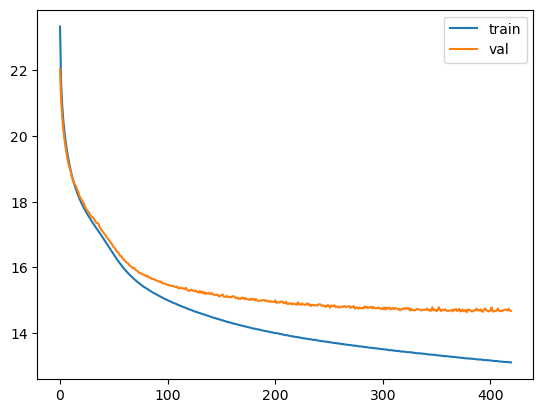

In [36]:
for k, v in losses_r.items():
    plt.plot(v, label=k)
plt.legend()
#plt.axis([0, 300, -30, 5])
plt.savefig("./sequential_files/real_inf_1/losses_r1.png")

In [37]:
# save proposal between rounds
model = fitted_flow

eqx.tree_serialise_leaves("./sequential_files/real_inf_1/posterior_r1.eqx", model)

In [39]:
# save sample parameters for next round
posterior = Transformed(fitted_flow, reparam_transform)

samples = posterior.sample(key, (10000,), condition=x_o_t)
print(np.shape(samples))
theta_2 = np.reshape(samples, (10000,16))

(10000, 1, 16)


In [ ]:
print(np.shape(theta_4))
tr2 = pd.DataFrame(theta_4)
tr2.to_csv("./plotting/dumm/tr4_100k.csv", index=False)

(100000, 16)


In [42]:
#theta_3 = pd.read_csv("../simulation/output/dummy_inf_2/r3/thetas_r3.csv")
#theta_3 = theta_3.to_numpy(dtype=np.float32)
#theta_2 = pd.read_csv("../simulation/output/dummy_inf_2/r2/thetas_r2.csv")
#theta_2 = theta_2.to_numpy(dtype=np.float32)
theta = pd.read_csv("../simulation/output/dummy_inf_2/r1/thetas_r1.csv")
theta = theta.to_numpy(dtype=np.float32)
np.shape(theta)

(10000, 16)

In [2]:
priors_dict = {
    "bottleneck_strength_domestic": scipy.stats.lognorm(s=0.9, loc=0, scale=25000),
    "bottleneck_strength_wild": scipy.stats.lognorm(s=1, loc=0, scale=9000),
    "bottleneck_time_domestic": scipy.stats.lognorm(s=0.3, loc=0, scale=3500),
    "bottleneck_time_wild": scipy.stats.lognorm(s=0.3, loc=0, scale=3500),
    "captive_time": scipy.stats.lognorm(s=0.5, loc=0, scale=np.exp(3)),
    "div_time": scipy.stats.lognorm(s=0.4, loc=10000, scale=50000),
    "mig_length_post_split": scipy.stats.lognorm(s=1.5, loc=0, scale=10000),
    "mig_length_wild": scipy.stats.lognorm(s=0.4, loc=1, scale=np.exp(2.5)),
    "mig_rate_captive": scipy.stats.lognorm(s=0.5, loc=0, scale=0.11),
    "mig_rate_post_split": scipy.stats.lognorm(s=1.1, loc=0, scale=0.04),
    "mig_rate_wild": scipy.stats.lognorm(s=0.5, loc=0, scale=0.08),
    "pop_size_wild_1": scipy.stats.lognorm(s=0.6, loc=30, scale=np.exp(8.7)),
    "pop_size_wild_2": scipy.stats.lognorm(s=0.4, loc=30, scale=np.exp(9.1)),
    "pop_size_captive": scipy.stats.lognorm(s=0.6, loc=0, scale=120),
    "pop_size_domestic_1": scipy.stats.lognorm(s=0.45, loc=0, scale=np.exp(9.1)),
    "pop_size_domestic_2": scipy.stats.lognorm(s=0.5, loc=5, scale=np.exp(9.4))

}

theta = []
for key, prior in priors_dict.items():
    theta.append(prior.rvs(10000))
theta = np.concatenate(theta, axis=0)
print(np.shape(theta))
theta = np.reshape(theta, (16,10000))
print(np.shape(theta))

(160000,)
(16, 10000)


In [40]:
params = {
    "bottleneck_strength_domestic": {"bins" : np.arange(0, 100000, 750), "lims" : [0, 100000]},
    "bottleneck_strength_wild": {"bins" : np.arange(0, 150000, 1500), "lims" : [0, 150000]},
    "bottleneck_time_domestic": {"bins" : np.arange(500, 11000, 100), "lims" : [500, 11000]},
    "bottleneck_time_wild": {"bins" : np.arange(1000, 7000, 50), "lims" : [1000, 7000]},
    "captive_time": {"bins" : np.arange(0, 100, 1), "lims" : [0, 100]},
    "div_time": {"bins" : np.arange(0, 300000, 3000), "lims" : [0, 300000]},
    "mig_length_post_split": {"bins" : np.arange(0, 100000, 1000), "lims" : [0, 100000]},
    "mig_length_wild": {"bins" : np.arange(0, 75, 1), "lims" : [0, 75]},
    "mig_rate_captive": {"bins" : np.arange(0, 0.6, 0.006), "lims" : [0, 0.6]},
    "mig_rate_post_split": {"bins" : np.arange(0, 0.2, 0.002), "lims" : [0, 0.2]},
    "mig_rate_wild": {"bins" : np.arange(0, 1, 0.01), "lims" : [0, 1]},
    "pop_size_wild_1": {"bins" : np.arange(0, 20000, 200), "lims" : [0, 20000]},
    "pop_size_wild_2": {"bins" : np.arange(0, 20000, 200), "lims" : [0, 20000]},
    "pop_size_captive": {"bins" : np.arange(0, 500, 5), "lims" : [0, 500]},
    "pop_size_domestic_1": {"bins" : np.arange(0, 50000, 500), "lims" : [0, 50000]},
    "pop_size_domestic_2": {"bins" : np.arange(0, 50000, 500), "lims" : [0, 50000]}
         }

names = ['bottleneck_strength_domestic',
         'bottleneck_strength_wild',
         'bottleneck_time_domestic',
         'bottleneck_time_wild',
         'captive_time',
         'div_time',
         'mig_length_post_split',
         'mig_length_wild',
         'mig_rate_captive',
         'mig_rate_post_split',
         'mig_rate_wild',
         'pop_size_wild_1',
         'pop_size_wild_2',
         'pop_size_captive',
         'pop_size_domestic_1',
         'pop_size_domestic_2']

In [23]:
#parameters used for dummy observed data
dummy_params =  [3000 , 10000, 2500, 4500, 25, 75000, 3000, 16, 0.15, 0.04, 0.1, 3000, 12000, 60, 12000, 15000]

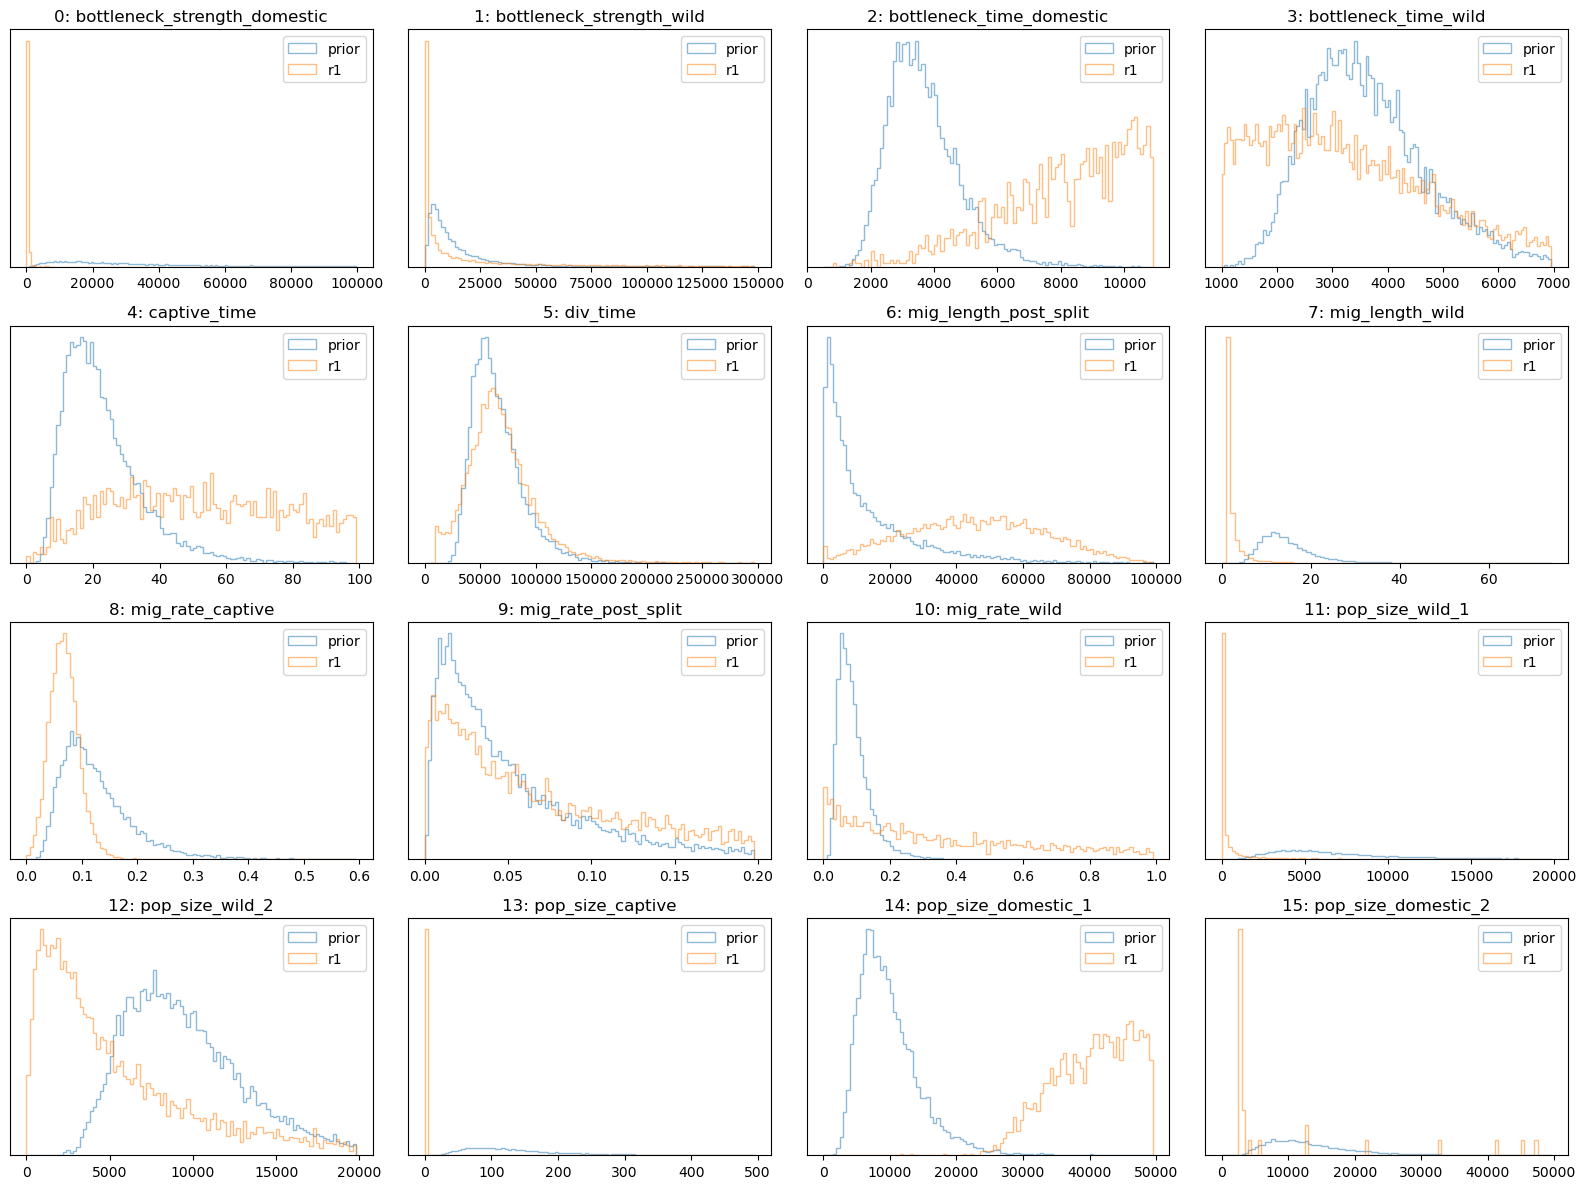

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(16, 12))  # 4x4 grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# plot parameter distributions
for num in range(0, 16):  # Only 16 plots for 4x4 grid
    stat = names[num]
    ax = axes[num]
    
    ax.hist(theta[:,num],
            alpha=0.5,
            label='prior', bins=params[stat]["bins"], density=True, histtype='step')
    
    ax.hist(theta_2[:,num],
            alpha=0.5,
            label='r1', bins=params[stat]["bins"], density=True, histtype='step')

    #ax.hist(theta_3[:,num],
        #    alpha=0.5,
        #    label='r2', bins=params[stat]["bins"], density=True, histtype='step')

    #ax.hist(theta_4[:,num],
     #       alpha=0.5,
      #      label='r3', bins=params[stat]["bins"], density=True, histtype='step')

    ax.legend(loc='upper right')
    ax.set_title(f'{num}: {stat}')
    #ax.axvline(x=dummy_params[num], color='red', linestyle='--')
    ax.set_yticks([])
    #ax.set_xlim(params[stat]["lims"])
    #ax.set_ylim(0, 0.0002)

# Hide any unused subplots if names has less than 16 entries
for i in range(len(names), 16):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("./plotting/real_inf_1/r1.png")
plt.show()